## 1. XGBoost: Fast Results with Explainability

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# explainability packages
import lime
import lime.lime_tabular
from lime.lime_text import LimeTextExplainer
import shap

from dataset import RentingRegressionDataset
from utils.plot_prices import plot_prices

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
df = pd.read_csv('data/lat_long_preprocessed_data.csv')

In [3]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Fit the one hot encoder to the training data so the dataset can be encoded
type_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
type_encoder.fit(train_df[['Type']])

# Create the datasets
train_dataset = RentingRegressionDataset(train_df, type_encoder, is_train=True)
test_dataset = RentingRegressionDataset(test_df, type_encoder, is_train=False)

Convert the datasets to NumPy arrays to work with XGBoost:

In [4]:
def dataset_to_numpy(dataset):
    features, targets = [], []
    for i in range(len(dataset)):
        feature, target = dataset[i]
        features.append(feature.numpy())
        targets.append(target.item())
    return np.array(features), np.array(targets)

In [5]:
X_train, y_train = dataset_to_numpy(train_dataset)
X_test, y_test = dataset_to_numpy(test_dataset)

Initialize XGBoost model:

In [6]:
model = xgb.XGBRegressor(
            objective='reg:squarederror',
            colsample_bytree=0.3,
            learning_rate=0.1,
            max_depth=5,
            alpha=10,
            n_estimators=1000, # 100
            reg_lambda=1,
)

Train the model:

In [7]:
model.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, ...)

In [8]:
predictions = model.predict(X_test)

In [9]:
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

In [10]:
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 378.6786848220314
Mean Squared Error (MSE): 483387.4789773974
Root Mean Squared Error (RMSE): 695.2607273371605
R-squared (R²): 0.8604087895489123


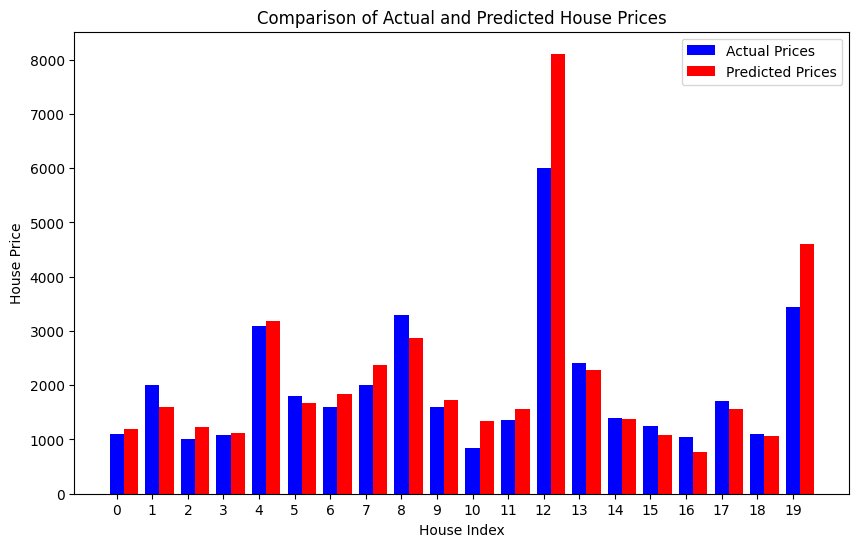

In [11]:
plot_prices(y_test, predictions, 20)

In [104]:
def plot_shap(test_idx: int = 0):
    feature_names = train_dataset.feature_names
    explainerXGB = shap.TreeExplainer(model, feature_names=feature_names)
    shap_values_XGB_test = explainerXGB.shap_values(X_test)
    explanation_XGB_test = shap.Explanation(values=shap_values_XGB_test[test_idx], 
                                        base_values=explainerXGB.expected_value, 
                                        data=X_test[test_idx], 
                                        feature_names=feature_names)
    shap.plots.waterfall(explanation_XGB_test, max_display=20)

In [146]:
def plot_lime(test_idx: int = 0):
    def preprocess_input(series_input):
        """Example of usage: model.predict([preprocess_input(test_df.iloc[0])])[0]"""

        series_input = series_input.copy()
        df_type = pd.DataFrame([[series_input['Type']]], columns=['Type'])
        house_type = type_encoder.transform(df_type).reshape(-1)
        descriptions = test_dataset.text_to_embeddings(series_input['Description'])

        for key in ['Deposit', 'Location', 'Cardinality', 'Price', 'Type', 'Description']:
            if key in series_input:
                series_input.pop(key)

        # Combine the transformed data
        input_val = np.hstack([house_type, descriptions, series_input.values])

        return input_val
    
    def make_wrapped_predict_fn(original_raw_data):
        """
        Creates a closure that captures additional attributes.

        :param original_raw_data: The original raw data.
        :return: A wrapped prediction function.
        """
        def wrapped_predict_fn(texts):
            """
            A wrapper function for the model's prediction function, compatible with LIME.

            :param texts: A list of text descriptions.
            :return: Predictions formatted for LIME.
            """
            predictions = []
            for text in texts:
                original_raw_data_copy = original_raw_data.copy()
                original_raw_data_copy['Description'] = text
                input_val = preprocess_input(original_raw_data_copy)
                pred = model.predict([input_val])[0]
                predictions.append(pred)

            return np.vstack((predictions, predictions)).T
        return wrapped_predict_fn

    explainer = LimeTextExplainer()
    sample_text = test_df.iloc[test_idx]['Description']

    wrapped_predict_fn_with_raw_data = make_wrapped_predict_fn(test_df.iloc[test_idx])
    exp = explainer.explain_instance(sample_text, wrapped_predict_fn_with_raw_data)
    exp.show_in_notebook()

    # print real and predicted price
    predicted_value = model.predict([preprocess_input(test_df.iloc[test_idx])])[0]
    print(f"Real price: {test_df.iloc[test_idx]['Price']}€")
    print(f"Predicted price: {round(predicted_value)}€")
    print(f"Difference: {round(abs(predicted_value - test_df.iloc[test_idx]['Price']))}€")

[02:44:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


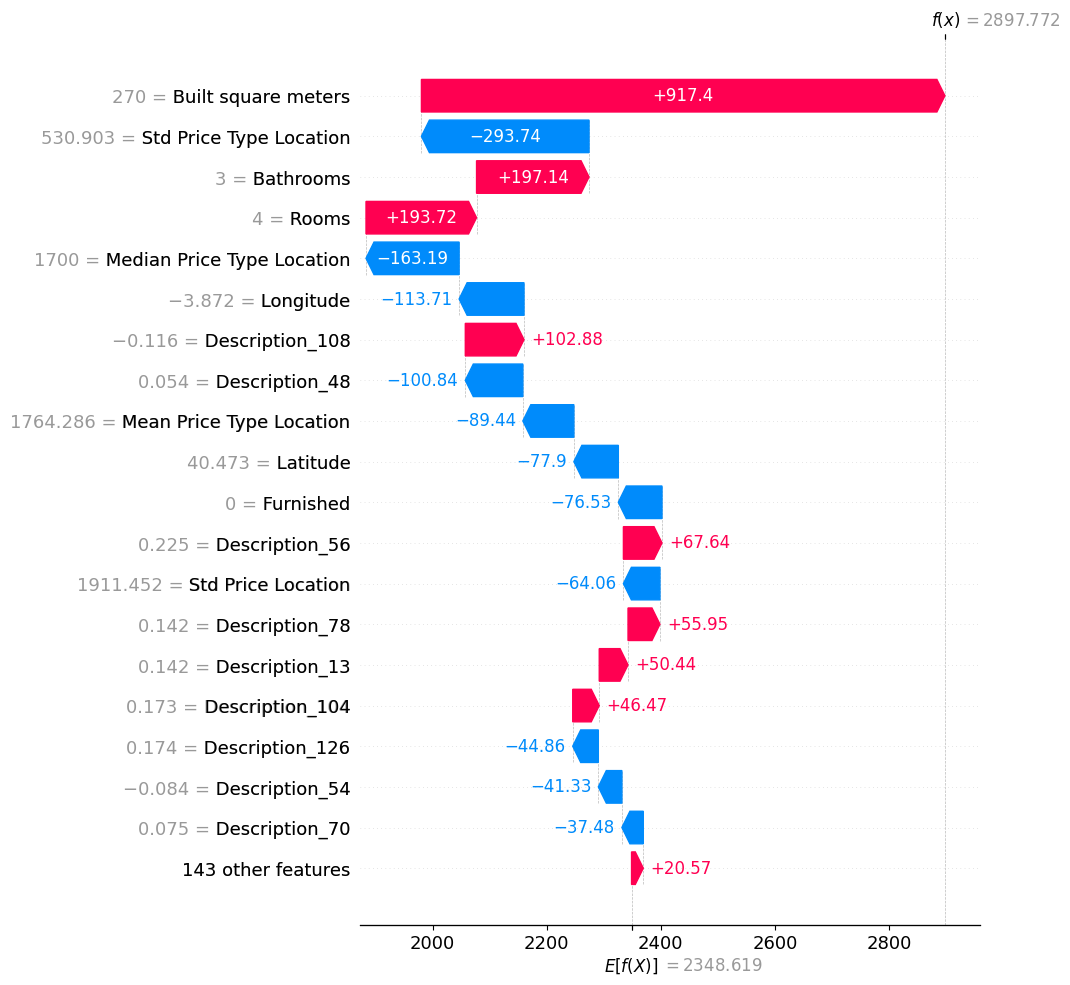

Real price: 2950€
Predicted price: 2898€
Difference: 52€


In [148]:
idx = 20

plot_shap(idx)
plot_lime(idx)

## 2. Transformer with Explainability: Great Results but with a less interpretable model

In [ ]:
from pytorch_lightning import Trainer
import torch